# The spectral solution

Evolve four models with DD, NN, DN and ND boundary condition. 
Their reflections cancel up to time L/v * 3 when the wave reenters the domain. 
This method requires the initial wave to have compact support within the domain. 

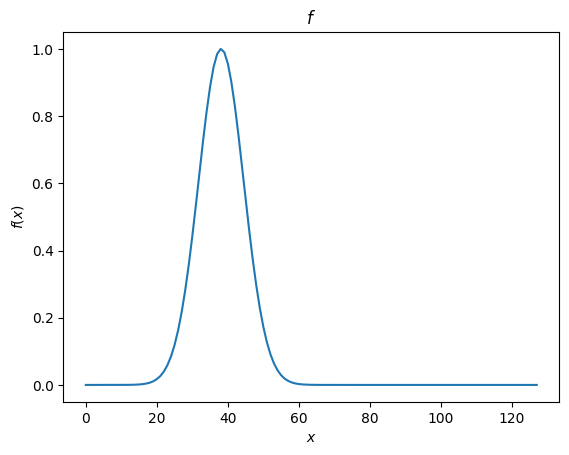

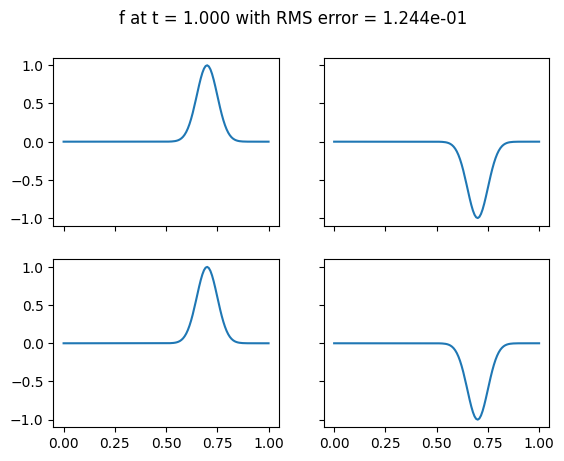

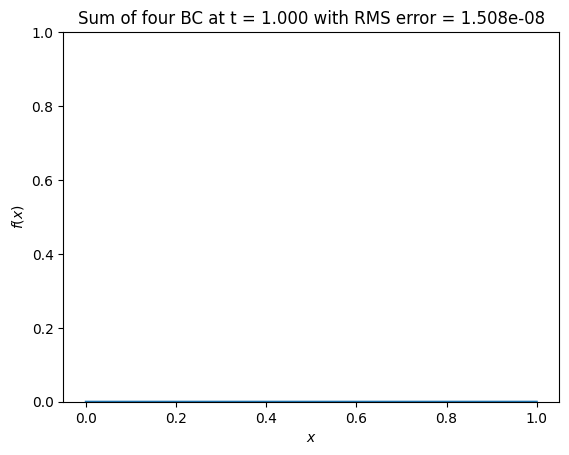

In [1]:
import spectral_derivative as sd
import numpy as np 
import matplotlib.pyplot as plt


L     = 1
N     = 128
x, dx = sd.computeX(0, L, N)
dt    = 1e-4
v     = 1
t     = 0
tend  = 1.0
r     = (v * dt)**2

def func(x, v, t):
    return np.exp(-(x-0.3 - t * v)**2/0.005)

def UR(x, v, t):
    return np.exp(-(x-1.7 + t * v)**2/0.005)


f  = func(x, v,   t     )
fm = func(x, v,   t - dt)

fs = np.zeros((*f.shape, 2, 4))

# Evolve four models in order for reflections to cancel
fs[:, 0, 0] = f
fs[:, 1, 0] = fm
fs[:, 0, 1] = f
fs[:, 1, 1] = fm
fs[:, 0, 2] = f
fs[:, 1, 2] = fm
fs[:, 0, 3] = f
fs[:, 1, 3] = fm

prefactors = np.array([ 1, 1, 1, 1]) * 0.25
ddfnum     = np.zeros(x.shape)
ddfnums    = np.zeros((*x.shape, 4))
  
plt.title(r"$f$")
plt.plot(f)
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.show()

while t < tend:
    for j, BC in enumerate([sd.NN, sd.ND, sd.DN, sd.DD]):
        ddf             = np.zeros(fs[:, 0, j].shape)
        p, ind1, ind2   = sd.selectBC(fs[:, 0, j], BC)
        ddfs, k         = sd.laplacianDtt1D(p, dx, BC)
        ddf[ind1:ind2] += ddfs

        
        fp = 2 * fs[:, 0, j] - fs[:, 1, j] + r * ddf
        fs[:, 1, j]  = fs[:, 0, j]
        fs[:, 0, j]  = fp
    t += dt 

fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, )
axs = axs.flatten()
fig.suptitle(f"f at t = {t:3.3f} with RMS error = {np.mean(np.abs(fs[:, 0, j] - func(x, v, t))):3.3e}")
for j, BC in enumerate([sd.NN, sd.ND, sd.DN, sd.DD]):
    axs[j].plot(x, fs[:, 0, j])
plt.show()

plt.title(f"Sum of four BC at t = {t:3.3f} with RMS error = {np.mean(np.abs(np.mean(fs[:, 0, :], axis=1) - func(x, v, t))):3.3e}")
plt.plot(x, np.mean(fs[:, 0, :], axis=1))
plt.ylim([0, 1])
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.show()